# Import & Install Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/SMBUD/')

In [ ]:
!pip install ydata_profiling sweetviz lux-api autoviz plotly matplotlib typing_extensions

In [ ]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import re

# MongoDB Extra Work

## Creating DataFrame from JSON files

In [ ]:
df_list = []
for i in range(1,11):
  df_list.append(pd.read_json('/content/drive/MyDrive/SMBUD/mongodatasets/_' + str(i) + '.json'))

df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.columns

Index(['name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'score_rank', 'positive', 'negative', 'estimated_owners',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu',
       'tags'],
      dtype='object')

## Interesting Plots

In [ ]:
def plot_pie(category):
    df_plot = df[[category]]
    df_plot = df_plot.explode(category)
    counts = df_plot[category].value_counts()
    top_counts = counts.head(10)
    other_counts = counts.iloc[10:].sum()
    top_counts = top_counts.append(pd.Series({'Other': other_counts}))
    colors = plt.cm.Paired(range(len(top_counts)))
    plt.figure(figsize=(20, 12))
    plt.pie(top_counts, labels=top_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title('Value Distribution of ' + category + ': Top 10 vs Others')
    plt.savefig('/content/drive/MyDrive/SMBUD/mongoplots/' + category)

<ipython-input-29-c0b61b87cefc>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_counts = top_counts.append(pd.Series({'Other': other_counts}))
<ipython-input-29-c0b61b87cefc>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_counts = top_counts.append(pd.Series({'Other': other_counts}))
<ipython-input-29-c0b61b87cefc>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_counts = top_counts.append(pd.Series({'Other': other_counts}))
<ipython-input-29-c0b61b87cefc>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_counts = top_counts.append(pd.Series({'Other': other_counts}))
<ipython-input-29-c0b61b87cefc>:7: FutureWarning

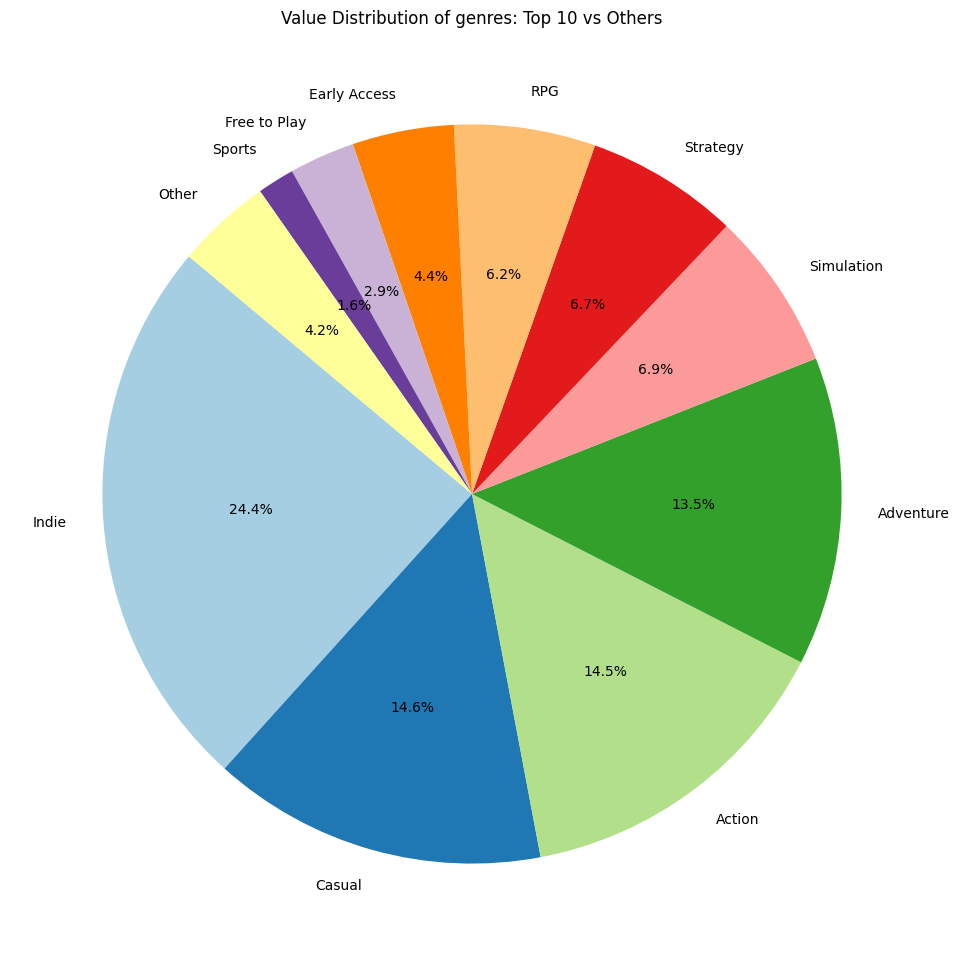

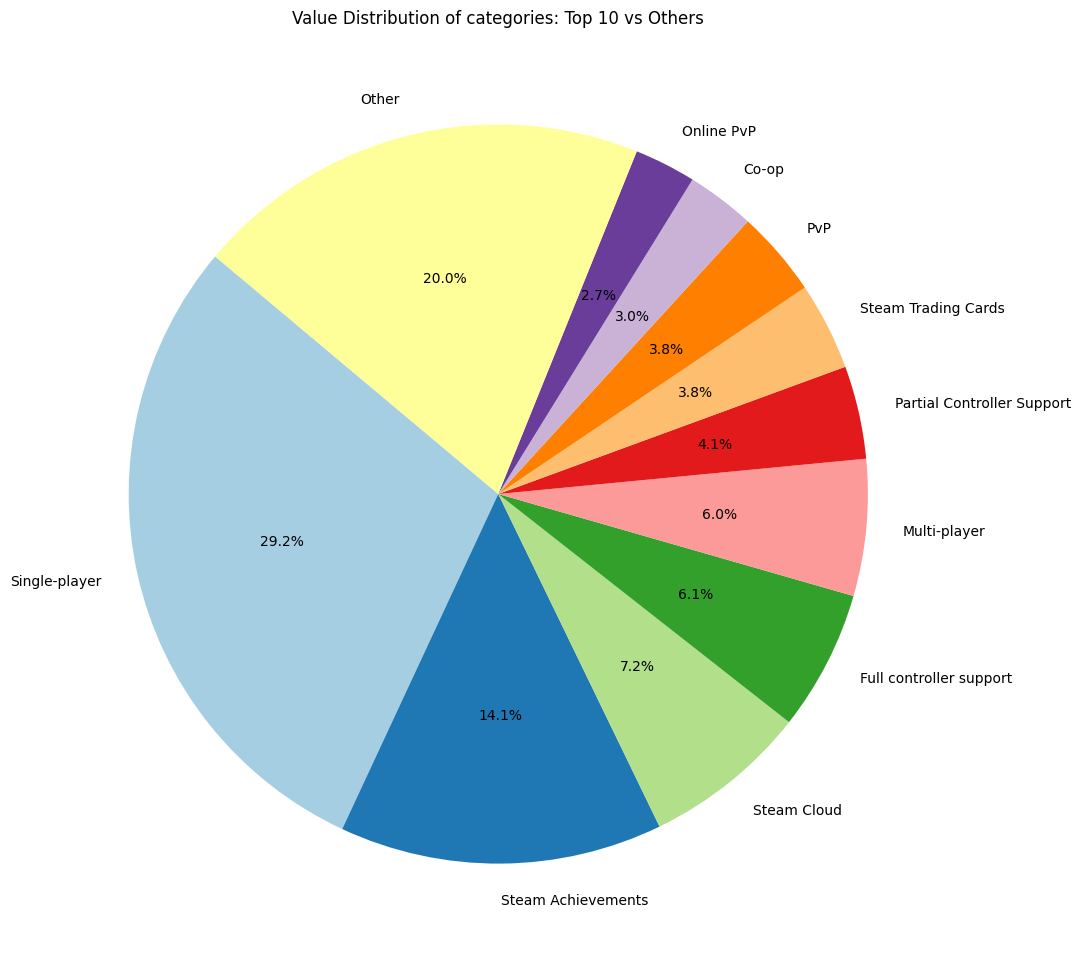

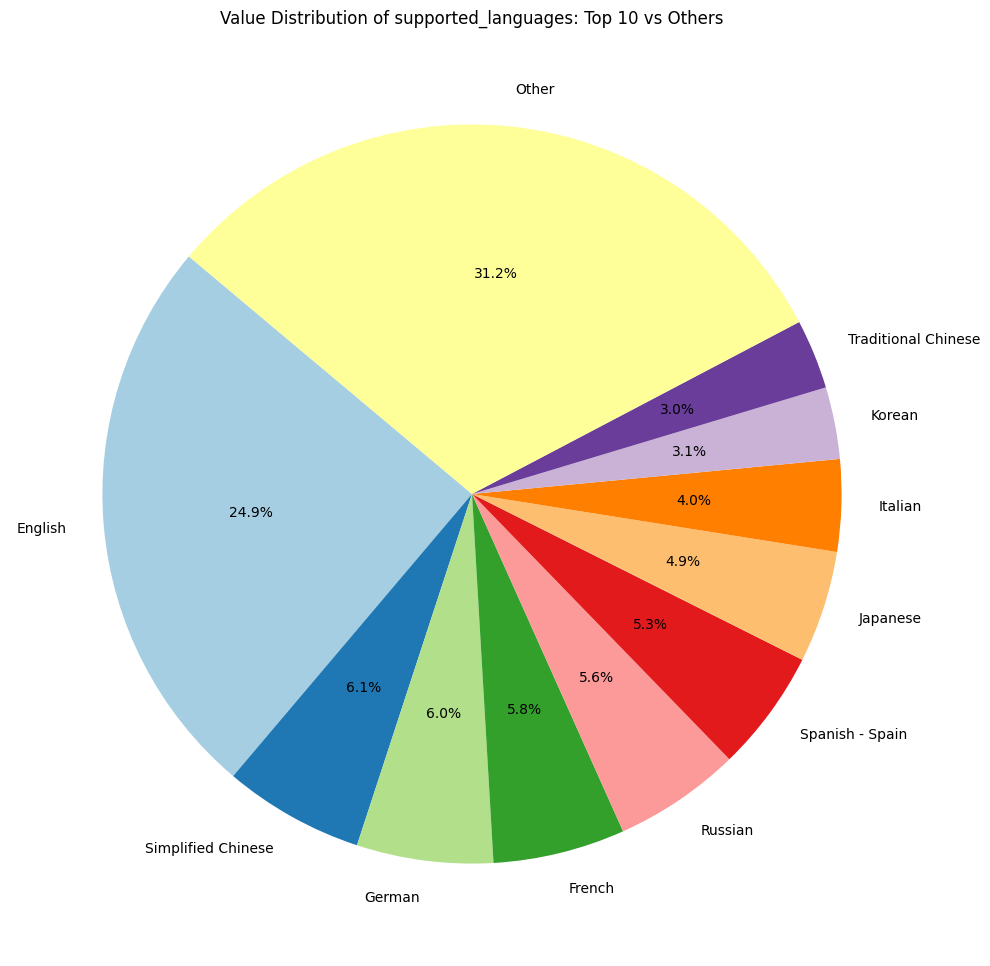

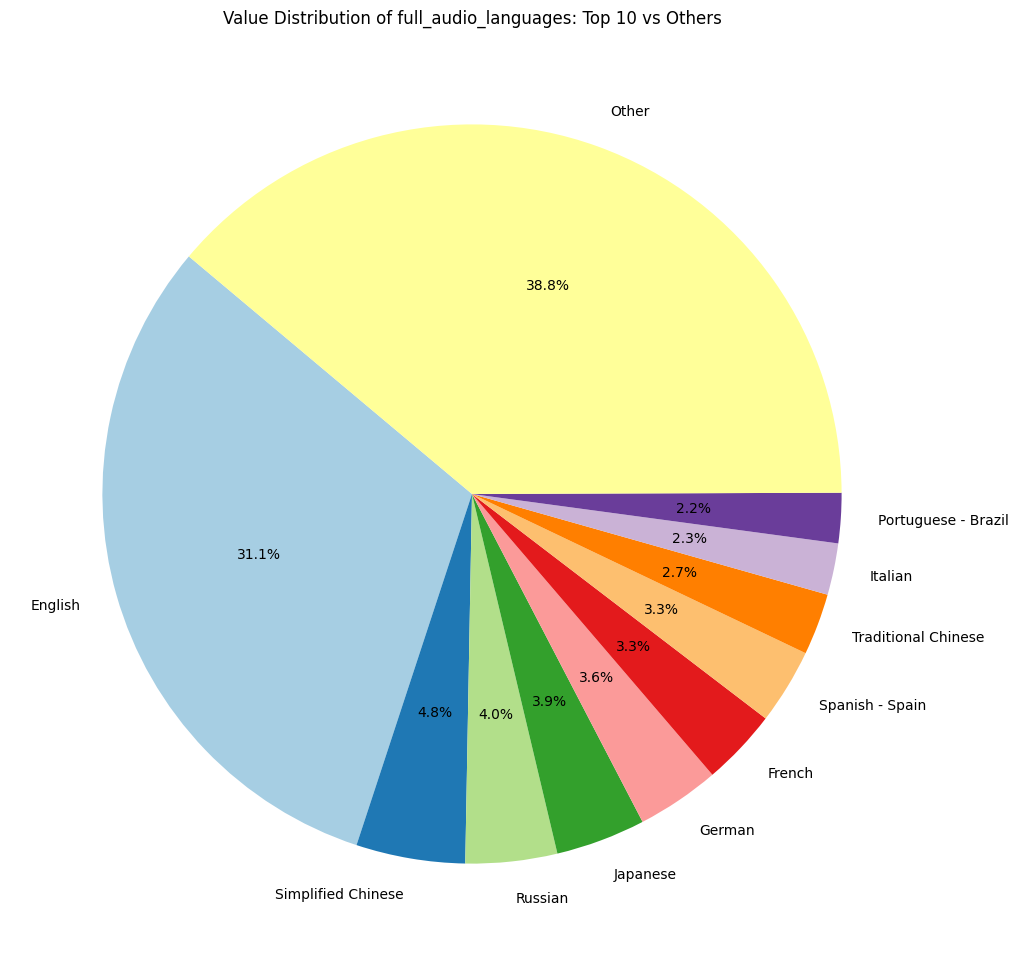

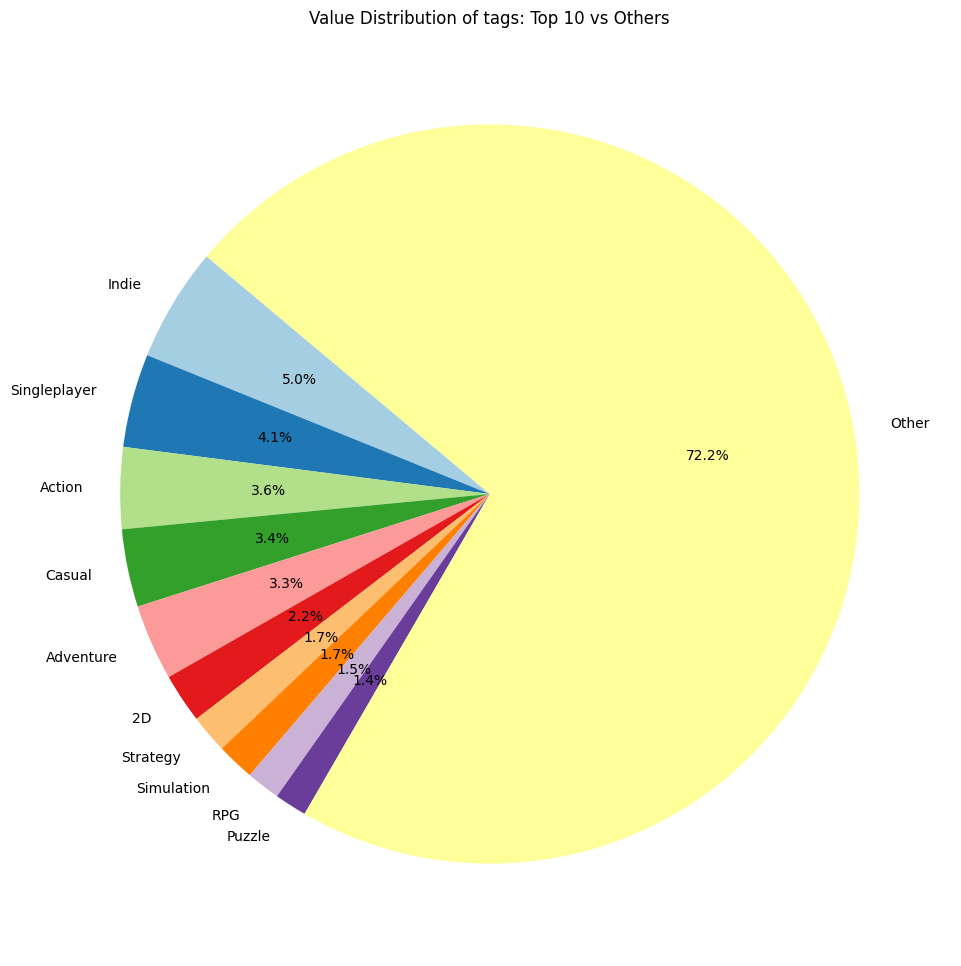

In [ ]:
categories = ["genres", "categories", "supported_languages", "full_audio_languages", "tags"]
for category in categories:
  plot_pie(category)

## Data Profiling

In [ ]:
def refactor_estimated_owners(string):
  match = re.match(r'(\d+) - (\d+)', string)
  if match:
      x, y = map(int, match.groups())
      return int((x + y) / 2)
  else:
      return np.NaN

In [ ]:
df_test = df.copy()

#dropping useless columns
df_test = df_test.drop(['detailed_description', 'about_the_game', 'short_description', 'header_image', 'website',
                        'support_url', 'support_email', 'movies', 'median_playtime_forever', 'median_playtime_2weeks',
                        'screenshots', 'metacritic_url', 'notes', 'packages'], axis=1)

#dropping unsupported analysis columns
df_test = df_test.drop(['supported_languages', 'full_audio_languages', 'developers', 'publishers', 'tags',
                        'categories', 'genres'], axis=1)

#refactoring estimated_owners
df_test['estimated_owners'] = df_test['estimated_owners'].apply(refactor_estimated_owners)

In [ ]:
#create a profile report in html
PROFILE = ProfileReport(df_test, title="Pandas Profiling Report")
PROFILE.to_file("/content/drive/MyDrive/SMBUD/First MongoDB Dataset Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def refactor_empty_strings(string):
  if string == "":
    return np.NaN
  else:
    return string

def refactor_zeros(value):
  if value == 0:
    return np.NaN
  else:
    return value

In [ ]:
#dropping duplicates
df_test = df_test.drop_duplicates()

#dropping incomplete columns
df_test = df_test.drop(['user_score'], axis=1) # only 4 values!

#replacing empty string or zeros with NaN to highlight data quality problems
df_test['reviews'] = df_test['reviews'].apply(refactor_empty_strings)
df_test['score_rank'] = df_test['score_rank'].apply(refactor_empty_strings)
df_test['metacritic_score'] = df_test['metacritic_score'].apply(refactor_zeros)

for idx, row in df_test.iterrows():
  if row['estimated_owners'] != 0 and row['average_playtime_forever'] == 0:
    df_test.at[idx, 'average_playtime_forever'] = np.NaN
  if row['estimated_owners'] != 0 and row['average_playtime_2weeks'] == 0:
    df_test.at[idx, 'average_playtime_2weeks'] = np.NaN
  if row['estimated_owners'] != 0 and row['peak_ccu'] == 0:
    df_test.at[idx, 'peak_ccu'] = np.NaN

df_test

,name,release_date,required_age,price,dlc_count,reviews,windows,mac,linux,metacritic_score,achievements,recommendations,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,peak_ccu
0,Galactic Bowling,"Oct 21, 2008",0,19.99,0,NaN,True,False,False,NaN,30,0,NaN,6,11,10000,NaN,NaN,NaN
1,Train Bandit,"Oct 12, 2017",0,0.99,0,NaN,True,True,False,NaN,12,0,NaN,53,5,10000,NaN,NaN,NaN
2,Jolt Project,"Nov 17, 2021",0,4.99,0,NaN,True,False,False,NaN,0,0,NaN,0,0,10000,NaN,NaN,NaN
3,Henosis™,"Jul 23, 2020",0,5.99,0,NaN,True,True,True,NaN,0,0,NaN,3,0,10000,NaN,NaN,NaN
4,Two Weeks in Painland,"Feb 3, 2020",0,0.00,0,NaN,True,True,False,NaN,17,0,NaN,50,8,10000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83555,Sex Simulator - Office Promotion,"Sep 16, 2023",0,3.99,0,NaN,True,True,True,NaN,3,0,NaN,0,0,10000,NaN,NaN,NaN
83556,UFindO,"Aug 21, 2023",0,0.49,0,NaN,True,False,False,NaN,10,0,NaN,8,1,10000,NaN,NaN,NaN
83557,UNDRESS!,"Oct 23, 2023",0,1.99,0,NaN,True,False,False,NaN,12,0,NaN,0,0,10000,NaN,NaN,NaN
83558,Oculant,"Nov 22, 2023",0,4.99,0,NaN,True,False,False,NaN,0,0,NaN,0,0,10000,NaN,NaN,NaN


In [ ]:
#create a profile report in html
PROFILE = ProfileReport(df_test, title="Pandas Profiling Report")
PROFILE.to_file("/content/drive/MyDrive/SMBUD/Second MongoDB Dataset Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#dropping incomplete columns
df_test = df_test.drop(['score_rank'], axis=1)

In [ ]:
#create a profile report in html
PROFILE = ProfileReport(df_test, title="Pandas Profiling Report")
PROFILE.to_file("/content/drive/MyDrive/SMBUD/Third MongoDB Dataset Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]